In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.applications import ResNet50

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 133
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 1
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = 'recurrent'

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 16
epochs = 100
learning_rate = 1e-4

workers = 4

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y[:,0,:])
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

## Recurrent: Conv1D Test

In [5]:
kernel = (3,3)
padding = 'valid'
regularizer = None

kernel1D = 9
padding1D = 'valid'

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

l1_1 = Conv2D(64, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(x)
l1_2 = Conv2D(64, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_1)
l1_3 = MaxPooling2D()(l1_2)
l2_1 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l1_3)
l2_2 = Conv2D(128, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_1)
l2_3 = MaxPooling2D()(l2_2)
l3_1 = Conv2D(256, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(l2_3)

l4_1 = Reshape((625, 256))(l3_1)

l5_1 = Conv1D(256, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l4_1)
l5_2 = MaxPooling1D()(l5_1)

l6_1 = Conv1D(128, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l5_2)
l6_2 = Conv1D(128, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l6_1)
l6_3 = MaxPooling1D()(l6_2)

l7_1 = Conv1D(64, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l6_3)
l7_2 = Conv1D(64, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l7_1)
l7_3 = Conv1D(3, kernel1D, padding=padding1D,
            activation=activation, activity_regularizer=regularizer)(l7_2)

l8_1 = Lambda(lambda x:x[:,-1,:,:])(x)
l8_2 = ZeroPadding1D(padding=1)(l8_1)
l8_3 = expand_dims(l7_3, axis=1)
l8_4 = expand_dims(l8_2, axis=1)
l8_5 = Concatenate(axis=1)([l8_3, l8_4])
#l8_6 = Conv2D(3,)

autoencoder = Model(input_x, l8_5)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 120, 120, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 118, 118, 64) 1792        cropping2d_1[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 116, 116, 64) 36928       conv2d_5[0][0]                   
______________________________________________________________________________________________

## Recurrent: Dense Test v1

In [4]:
kernel = (3,3)
padding = 'valid'
activation = 'relu'
regularizer = None

kernel1D = 9
padding1D = 'valid'

def block(x, filters, kernel):
    x = Conv2D(filters, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(x)
    x = Conv2D(filters, kernel, padding=padding, activation=activation,
            activity_regularizer=regularizer)(x)
    x = MaxPooling2D()(x)
    return x

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

for i in range(0, 4):
    x = block(x, 15 * (2**i), kernel)
z = Lambda(lambda x:x[:,:,-1,:])(input_x)
z = Flatten()(z)
z = Dense(3*120, activation=activation, activity_regularizer=regularizer)(z)
x = Flatten()(x)
x = Dense(3*120, activation=activation, activity_regularizer=regularizer)(x)
x = add([x,z])
x = Dense(3*120, activation=activation, activity_regularizer=regularizer)(x)
x = Reshape((120,3))(x)


autoencoder = Model(input_x, x)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 118, 118, 15) 420         cropping2d[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 116, 116, 15) 2040        conv2d[0][0]                     
______________________________________________________________________________________________

## Recurrent: Conv1D Dense v2

In [4]:
kernel = (3,3)
padding = 'valid'
activation = 'relu'
regularizer = None
momentum = 0.8

kernel1D = 9
padding1D = 'valid'

def block(x, filters, kernel):
    x = Conv2D(filters, kernel, padding=padding)(x)
    #x = BatchNormalization(momentum=momentum)(x)
    x = Conv2D(filters, kernel, padding=padding)(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    return x

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

for i in range(0, 4):
    x = block(x, 15 * (2**i), kernel)
z = Lambda(lambda x:x[:,:,-1,:])(input_x)
z = Flatten()(z)
z = Dense(3*120, activation=activation, activity_regularizer=regularizer)(z)
x = Flatten()(x)
x = Dense(3*120, activation=activation, activity_regularizer=regularizer)(x)
x = add([x,z])
x = Dense(3*120, activation=activation, activity_regularizer=regularizer)(x)
x = Reshape((120,3))(x)
x = Conv1D(3, kernel_size=3, padding='same', activation=activation, activity_regularizer=regularizer)(x)


autoencoder = Model(input_x, x)
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 118, 118, 15) 420         cropping2d[0][0]                 
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 116, 116, 15) 2040        conv2d[0][0]                     
______________________________________________________________________________________________

## Resnet?

In [4]:
kernel = (3,3)
padding = 'valid'
activation = 'relu'
regularizer = None
momentum = 0.8

n_blocks = 16

def block(input, kernels):
    x = Conv2D(kernels, kernel_size=3, strides=1, padding='same')(input)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1,2])(x)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
    x = add([x, input])
    return x

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

x_start = Conv2D(64, kernel_size=7, strides=1, padding='same')(x)
x_start = PReLU(shared_axes=[1,2])(x_start)

x = block(x_start, 64)
for i in range(n_blocks-1):
    x = block(x, 64)

x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization(momentum=0.8)(x)
x = add([x, x_start])

x = AveragePooling2D()(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 120, 120, 64) 9472        cropping2d[0][0]                 
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 120, 120, 64) 64          conv2d[0][0]                     
____________________________________________________________________________________

## Resnet Too

In [15]:
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)

x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)
#x = Reshape((1,120,3))(x)
#
#z = Lambda(lambda x:x[:,:,-1,:])(input_x)
#z = expand_dims(z, axis=1)
#x = Concatenate(axis=1)([x,z])

#x = Conv2D(3, kernel_size=2, strides=(2,1), padding='same')(x)
#x = BatchNormalization()(x)
#x = PReLU()(x)
x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 360), (None, 1, 120, 3)]

## Resnet Tre

In [4]:
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Cropping2D(((0,0),(13,0)))(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)

x = AveragePooling2D()(x)
x = Flatten()(x)
z = Lambda(lambda x:x[:,:,-1,:])(input_x)
z = Flatten()(z)
x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)
#x = add([x,z])
#x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)

x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
cropping2d (Cropping2D)         (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 64) 9472        cropping2d[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [6]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/100
1000/1000 [==============================] - 124s 124ms/step - loss: 0.0888
Epoch 2/100
1000/1000 [==============================] - 127s 127ms/step - loss: 0.0432
Epoch 3/100
1000/1000 [==============================] - 126s 126ms/step - loss: 0.0347
Epoch 4/100
1000/1000 [==============================] - 127s 127ms/step - loss: 0.0294
Epoch 5/100
1000/1000 [==============================] - 126s 126ms/step - loss: 0.0268
Epoch 6/100
1000/1000 [==============================] - 126s 126ms/step - loss: 0.0235
Epoch 7/100
1000/1000 [==============================] - 126s 126ms/step - loss: 0.0206
Epoch 8/100
1000/1000 [==============================] - 127s 127ms/step - loss: 0.0176
Epoch 9/100
1000/1000 [==============================] - 128s 128ms/step - loss: 0.0149
Epoch 10/100
1000/1000 [==============================] - 127s 127ms/step - loss: 0.0142
Epoch 11/100
1000/1000 [==============================] - 127s 127ms/step - loss: 0.0125
Epoch 12/100
1000/1000 [======

&lt;tensorflow.python.keras.callbacks.History at 0x7f214c0ca0a0&gt;

In [136]:
autoencoder.save_weights('saved_models/'+'recurrent')

In [137]:
autoencoder.load_weights('saved_models/'+'recurrent')

&lt;tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7f20045d05b0&gt;

(120, 3)


&lt;matplotlib.image.AxesImage at 0x7f20b43f1070&gt;

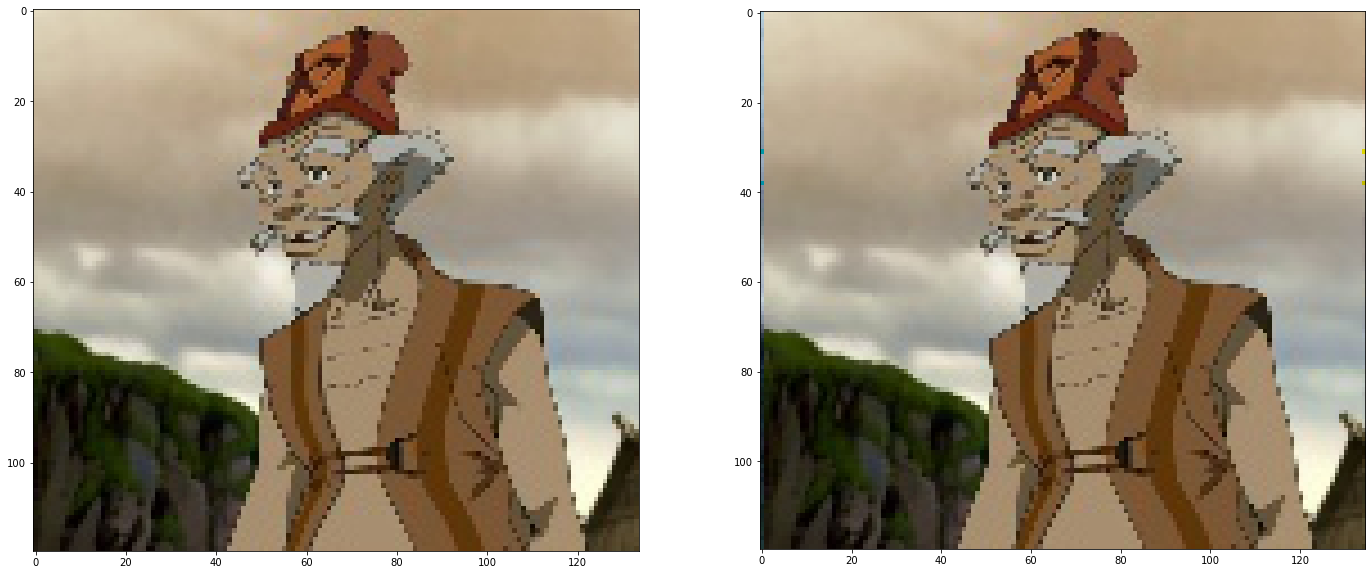

In [9]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)[:,0,:]
print(image_y_true.shape)
image_y_true = np.expand_dims(image_y_true, axis=1)
image_y_pred = autoencoder.predict(np.expand_dims(image_x, 0))[0]
image_y_pred = np.expand_dims(image_y_pred, axis=1)
image_y_pred_flip = autoencoder.predict(np.expand_dims(np.flip(image_x, axis=1), 0))[0]
image_y_pred_flip = np.flip(image_y_pred_flip, axis=1)
image_y_pred_flip = np.expand_dims(image_y_pred_flip, axis=1)
image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred), axis=1)
image_pred = np.concatenate((image_y_pred_flip, image_pred), axis=1)
plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

&lt;matplotlib.image.AxesImage at 0x7f2004c2cee0&gt;

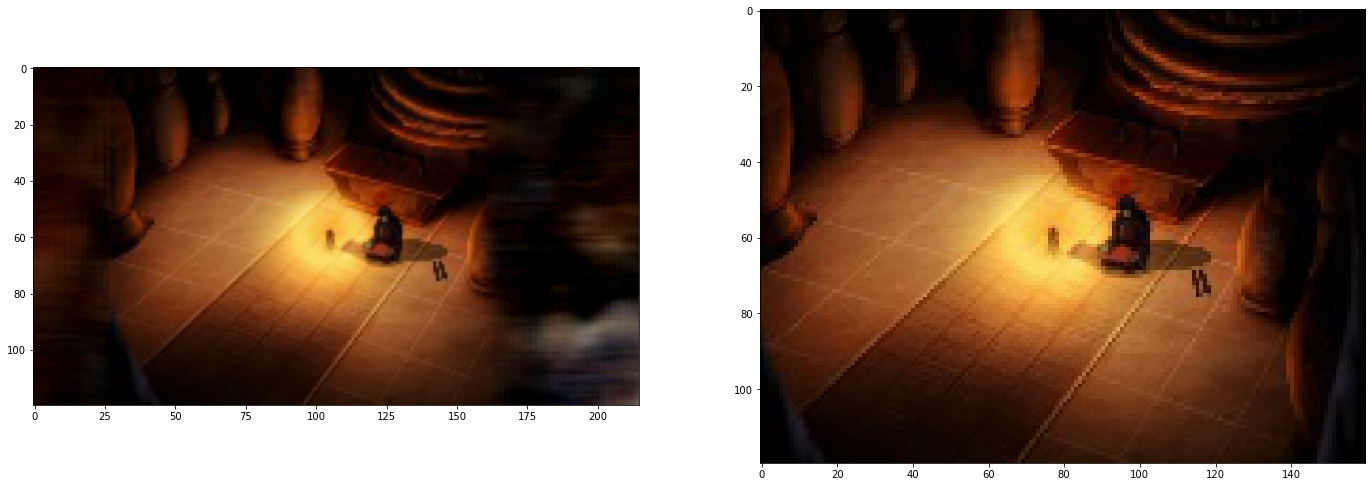

In [138]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_x_true = image_x
image_x_flip = np.flip(image_x, axis=1)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
slices = []
slices_flip = []
image_y_flip = np.expand_dims(image_x_flip[:,-1,:], axis=1)

for i in range(0, 2*27):
    #slice_y = np.expand_dims(slices[-1], axis=1)
    slice_y = autoencoder.predict(np.expand_dims(image_x[:,i:,:], 0))[0]
    slice_y = np.expand_dims(slice_y, axis=1)
    slices.append(slice_y)
    image_x = np.concatenate((image_x, slice_y), axis=1)

for i in range(27):
    slice_y = autoencoder.predict(np.expand_dims(image_x_flip[:,i:,:], 0))[0]
    slice_y = np.expand_dims(slice_y, axis=1)
    slices_flip.append(slice_y)
    image_x_flip = np.concatenate((image_x_flip, slice_y), axis=1)
    image_y_flip = np.concatenate((image_y_flip, slice_y), axis=1)
image_y_flip = np.flip(image_y_flip, axis=1)

image_true = np.concatenate((image_x_true, image_y_true), axis=1)

image_x = np.concatenate((image_y_flip, image_x), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_x)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_true)

In [2]:
resnet = ResNet50()
resnet.summary()

Model: &quot;resnet50&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_________________________________________________________________________________

In [147]:
from tensorflow.keras.layers import LSTM

input_x = autoencoder.input
output = autoencoder.outputs[-1]

x = Flatten()(output)
x = LSTM(27, return_sequences=True)(x)

model = Model(input_x, x)
model.summary()

ValueError: Input 0 of layer lstm_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 360]

In [134]:
print(autoencoder.outputs[-1])

Tensor(&quot;reshape/Identity:0&quot;, shape=(None, 120, 3), dtype=float32)
